In [1]:
# for numerical analysis
import numpy as np # linear algebra

# to store and process in a dataframe
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualizations, for ploting graphs
import matplotlib.pyplot as plt

# image processing
import matplotlib.image as mpimg

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# advanced ploting
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Image manipulations
from PIL import Image

# Timing utility
from timeit import default_timer as timer

from IPython.core.interactiveshell import InteractiveShell

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# PyTorch
import torchvision
from torchvision import transforms, datasets, models

import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d
from torch.nn import Module, Softmax, BatchNorm2d, Dropout

import gc

In [4]:
TRAIN_PATH        = 'data/ecg_img/train'

transform         = transforms.Compose(
                                       [transforms.Resize([120,120]),
                                        transforms.Grayscale(), 
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5))
                                       ])
  
train_data_set    = datasets.ImageFolder(root=TRAIN_PATH, transform=transform)

batch_size=32

train_data_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True)

In [5]:
TEST_PATH        = '/workspaces/ecg-classification/data/ecg_img/test'
  
test_data_set    = datasets.ImageFolder(root=TEST_PATH, transform=transform)

test_data_loader = DataLoader(test_data_set, batch_size=batch_size, shuffle=True)

In [6]:
# Run this to test your data loader

images, labels = next(iter(train_data_loader))

In [7]:
print(type(images))

print(images.size())

print("")
print("Batch Size:   ",images.size()[0])
print("Channel Size: ",images.size()[1])
print("Image Height: ",images.size()[2])
print("Image Width:  ",images.size()[3])

<class 'torch.Tensor'>
torch.Size([32, 1, 120, 120])

Batch Size:    32
Channel Size:  1
Image Height:  120
Image Width:   120


In [8]:
# CNN Architect

class ConvNet_1(nn.Module):
    
    def __init__(self):
        
        super(ConvNet_1, self).__init__()

        self.layer_1  = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)
        
        self.relu1    = nn.ReLU(inplace=True)
        
        self.maxpool1 = MaxPool2d(kernel_size=2)
        

        self.layer_2  = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1)
        
        self.relu2    = nn.ReLU(inplace=True)
        
        self.maxpool2 = MaxPool2d(kernel_size=2)
        
        self.drop_out = nn.Dropout()
        
        
        # out_channels = 4, number of classes = 5
        
        # image width = 120, image height = 120 after two maxpooling 120 -> 60 -> 30
        
        self.fc1 = nn.Linear(4 * 30 * 30, 5)
        
    # Defining the forward pass

    def forward(self, x):
        
        out = self.layer_1(x)
        
        out = self.relu1(out)
        
        out = self.maxpool1(out)
        
        
        out = self.layer_2(out)
        
        out = self.relu2(out)
        
        out = self.maxpool2(out)
        
        
        out = out.reshape(out.size(0), -1)
        
        out = self.drop_out(out)
        
        out = self.fc1(out)
        
        return out
    
# Define Model

model_1 = ConvNet_1()

print(model_1)

ConvNet_1(
  (layer_1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3600, out_features=5, bias=True)
)


In [9]:
# Define Criterion

criterion = nn.CrossEntropyLoss()

# Define Optimizer

optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Whether to train on a gpu and Number of gpus

if cuda.is_available(): 
    
    print(f'{cuda.device_count()} number of gpus are detected and available.')
    
else:
        
    print(f'Train on gpu is not available')

Train on gpu is not available


Devise is cpu and model is started training.
Epoch [1/1], Step [300/1162], Loss: 0.8156, Accuracy: 75.00%
Epoch [1/1], Step [600/1162], Loss: 0.4081, Accuracy: 90.62%
Epoch [1/1], Step [900/1162], Loss: 0.1076, Accuracy: 100.00%
tensor([[21753,  3145,  1019,  3068,   573],
        [   76,  3186,    63,    65,     3],
        [   22,     4,  1041,    18,     1],
        [  270,    78,    98,  2624,    53],
        [    1,     0,     1,     5,    11]], dtype=torch.int32)
Finished Training


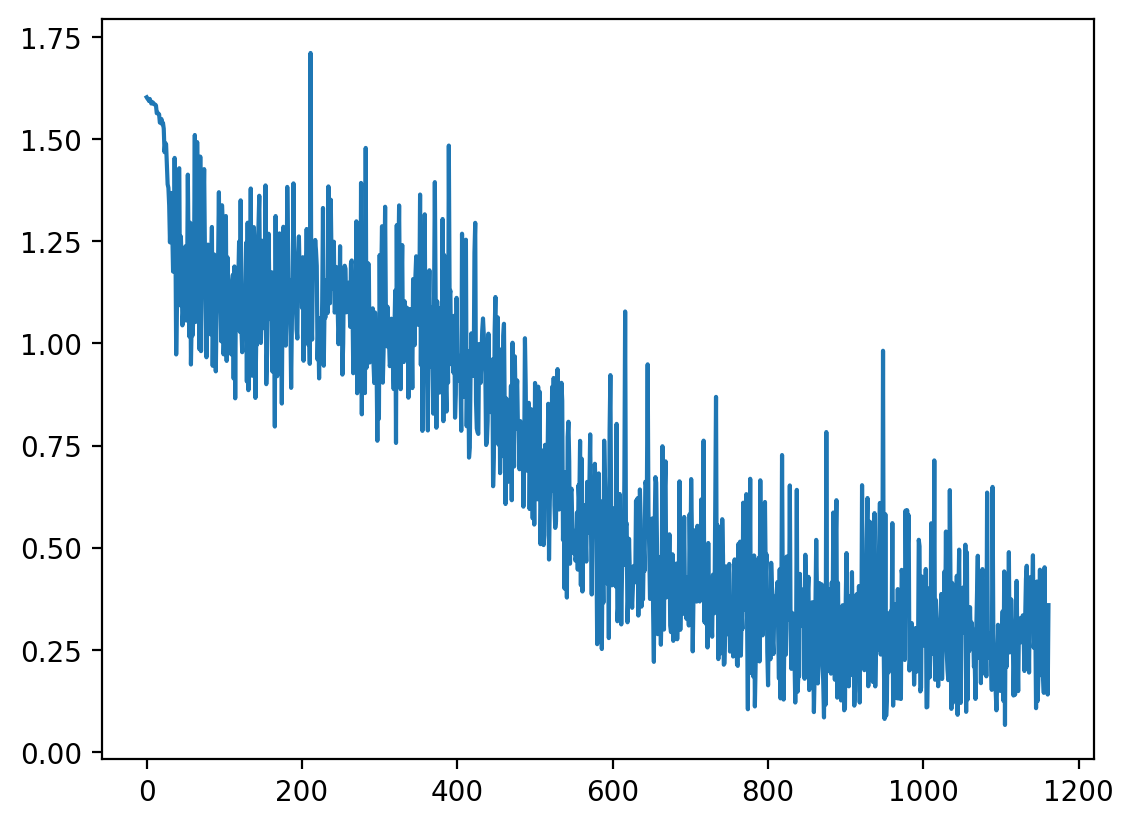

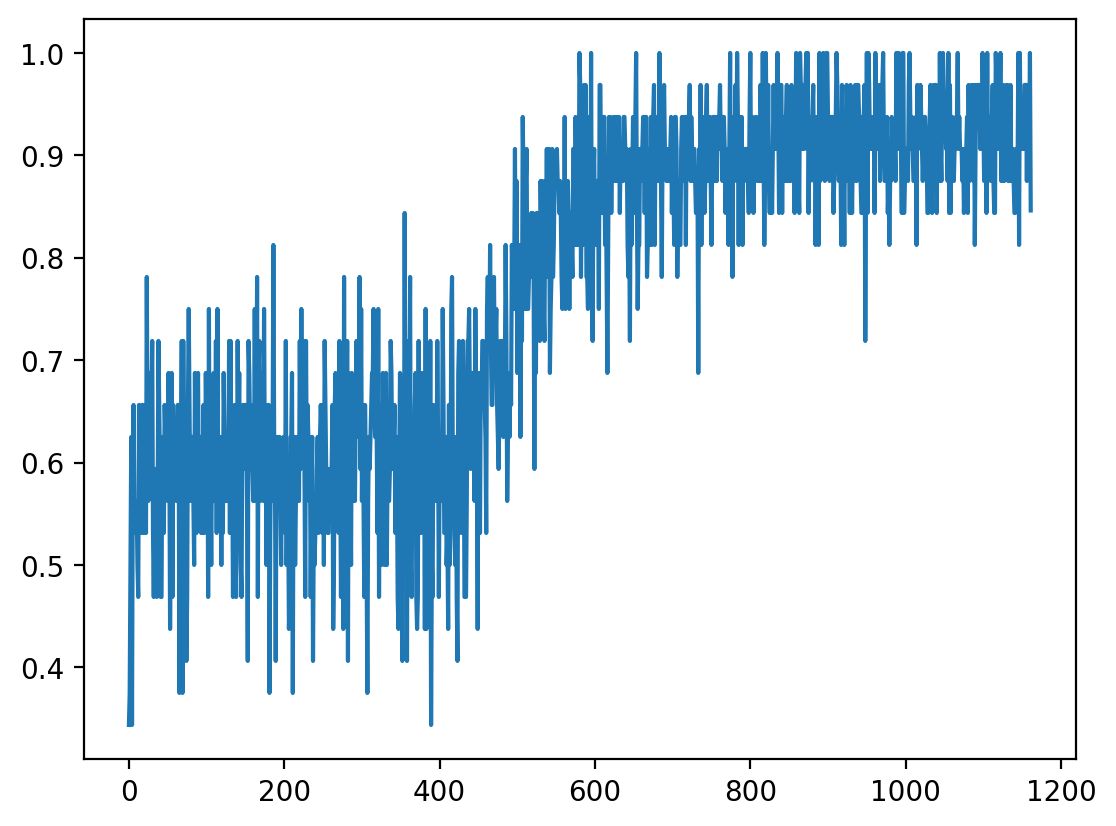

In [11]:
# This part is working

# Train the model

if torch.cuda.is_available():
    
    MODEL = model_1.cuda()
    CRITERION = criterion.cuda()
    print(f'Model is started training on {cuda.device_count()} number of gpus.')
    print("Devise is cuda")
    
else:
    
    MODEL = model_1
    CRITERION = criterion
    print("Devise is cpu and model is started training.")

total_step = len(train_data_loader)
loss_list = []
acc_list = []

num_epochs = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

all_con_mat = torch.zeros([num_epochs, 5, 5], dtype=torch.int32, device=device)

for epoch in range(num_epochs):
    
    # define empty tensor 5*5 beginning of every epoch
    # tensor [row,column]
    con_mat = torch.zeros([5, 5], dtype=torch.int32, device=device)
    
    for i, data in enumerate(train_data_loader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # optimization
        optimizer.zero_grad()
        
        # Forward to get output
        outputs = MODEL(inputs)
        # Calculate Loss
        loss = CRITERION(outputs, labels)
        # Backward propagation
        loss.backward()
        # Updating parameters
        optimizer.step()
        
        # Store loss
        loss_list.append(loss.item())
    
        # Calculate labels size
        total = labels.size(0)
        
        # Outputs.data has dimension batch size * 5
        # torch.max returns the max value of elements(_) and their indices(predicted) in the tensor array
        _, predicted = torch.max(outputs.data, 1)
        
        # Calculate total number of correct labels 
        correct = (predicted == labels).sum().item()
        
        # Store accuracy
        acc_list.append(correct / total)
        
        
        # Build Confusion Matrix
        for element in range(total):
            
            # con_mat[row,column]
            # con_mat[predictions, actual]
            
            con_mat[predicted[element].item()-1][labels[element].item()-1] += 1

        if (i + 1) % 300 == 0:                             # every 300 mini-batches...
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
    print(con_mat)
            
    all_con_mat[epoch] = con_mat            
            
print('Finished Training')

plt.plot(loss_list);
plt.show();

plt.plot(acc_list);
plt.show();

In [12]:
# RECALL

# PRECISION

# F1-score = 2 × (precision × recall)/(precision + recall)

class_list = ['N', 'Q', 'S', 'V', 'F']

f1_score_list=[0,0,0,0,0]

precision_list=[0,0,0,0,0]

recall_list=[0,0,0,0,0]

delta = 0.0000000000001

for i in range(torch.sum(con_mat, dim=0).size(0)): 
    
    recall_list[i] = con_mat[i][i].item()/(torch.sum(con_mat, dim=0)[i].item()+delta)
    
    precision_list[i] = con_mat[i][i].item()/(torch.sum(con_mat, dim=1)[i].item()+delta)
    
    f1_score_list[i] = 2 * precision_list[i]*recall_list[i]/(precision_list[i]+recall_list[i]+delta)
    
    print('class: {:<2},total number of class: {:>5}, Correctly predicted: {:>5}, Recall: {:.2f}%, Precision: {:.2f}%, F1-Score: {:.2f}%'
          
                  .format(class_list[i],
                          torch.sum(con_mat, dim=0)[i].item(),
                          con_mat[i][i].item(), 
                          recall_list[i],
                          precision_list[i],
                          f1_score_list[i]
                         ))

class: N ,total number of class: 22122, Correctly predicted: 21753, Recall: 0.98%, Precision: 0.74%, F1-Score: 0.84%
class: Q ,total number of class:  6413, Correctly predicted:  3186, Recall: 0.50%, Precision: 0.94%, F1-Score: 0.65%
class: S ,total number of class:  2222, Correctly predicted:  1041, Recall: 0.47%, Precision: 0.96%, F1-Score: 0.63%
class: V ,total number of class:  5780, Correctly predicted:  2624, Recall: 0.45%, Precision: 0.84%, F1-Score: 0.59%
class: F ,total number of class:   641, Correctly predicted:    11, Recall: 0.02%, Precision: 0.61%, F1-Score: 0.03%


cpu
Epoch [1/5], Step [300/1162], Loss: 0.3788, Accuracy: 87.50%
Epoch [1/5], Step [600/1162], Loss: 0.2002, Accuracy: 93.75%
Epoch [1/5], Step [900/1162], Loss: 0.2557, Accuracy: 93.75%
tensor([[21690,   359,   160,   668,   269],
        [  114,  5906,     1,    86,     4],
        [   36,    24,  2013,    20,     3],
        [  260,   123,    47,  4967,   116],
        [   22,     1,     1,    39,   249]], dtype=torch.int32)
class name: N, total number of class: 22122, Correctly predicted: 21690, Recall: 0.98%, Precision: 0.94%, F1-Score: 0.96%
class name: Q, total number of class:  6413, Correctly predicted:  5906, Recall: 0.92%, Precision: 0.97%, F1-Score: 0.94%
class name: S, total number of class:  2222, Correctly predicted:  2013, Recall: 0.91%, Precision: 0.96%, F1-Score: 0.93%
class name: V, total number of class:  5780, Correctly predicted:  4967, Recall: 0.86%, Precision: 0.90%, F1-Score: 0.88%
class name: F, total number of class:   641, Correctly predicted:   249, Recall:

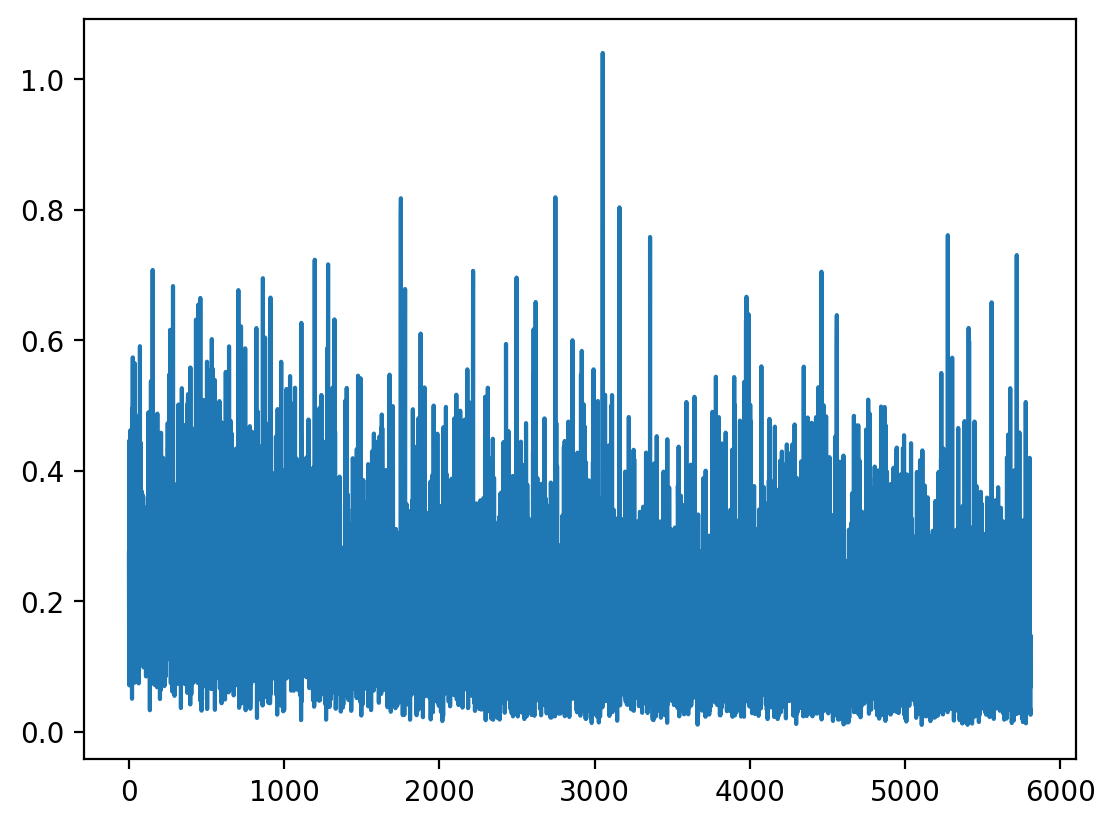

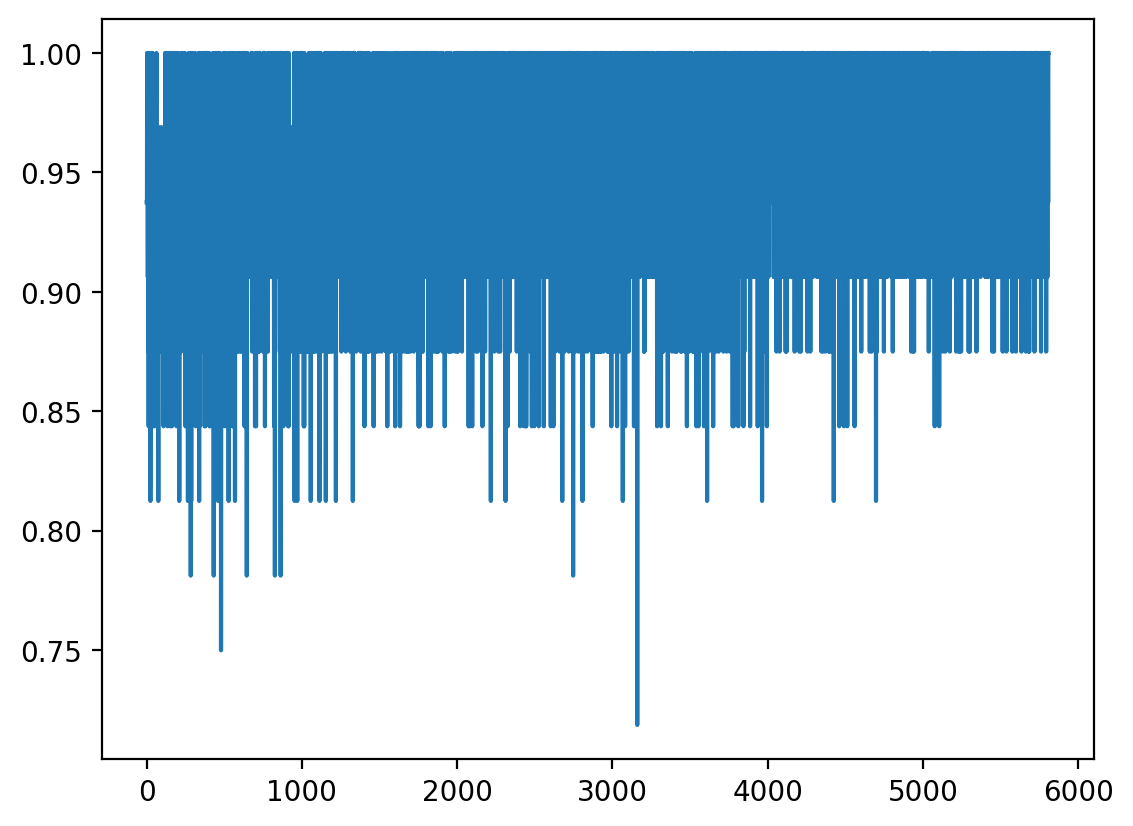

In [13]:
# This part is working

if torch.cuda.is_available():
    
    MODEL = model_1.cuda()
    CRITERION = criterion.cuda()
    print("cuda")
    
else:
    
    MODEL = model_1
    CRITERION = criterion
    print("cpu")

# Train the model

total_step = len(train_data_loader)
loss_list = []
acc_list = []

num_epochs = 5

class_list = ['N', 'Q', 'S', 'V', 'F']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

all_con_mat = torch.zeros([num_epochs, 5, 5], dtype=torch.int32, device=device)

for epoch in range(num_epochs):
    
    f1_score_list=[0,0,0,0,0]

    precision_list=[0,0,0,0,0]

    recall_list=[0,0,0,0,0]
    
    delta = 0.0000000000001 
    
    # define empty tensor 5*5 beginning of every epoch
    # tensor [row,column]
    con_mat = torch.zeros([5, 5], dtype=torch.int32, device=device)
    
    for i, data in enumerate(train_data_loader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # optimization
        optimizer.zero_grad()
        
        # Forward to get output
        outputs = MODEL(inputs)
        # Calculate Loss
        loss = CRITERION(outputs, labels)
        # Backward propagation
        loss.backward()
        # Updating parameters
        optimizer.step()
        
        # Store loss
        loss_list.append(loss.item())
    
        # Calculate labels size
        total = labels.size(0)
        
        # Outputs.data has dimension batch size * 5
        # torch.max returns the max value of elements(_) and their indices(predicted) in the tensor array
        _, predicted = torch.max(outputs.data, 1)
        
        # Calculate total number of correct labels 
        correct = (predicted == labels).sum().item()
        
        # Store accuracy
        acc_list.append(correct / total)
        
        for element in range(total):
            
            # con_mat[row,column]
            # con_mat[predictions, actual]
            con_mat[predicted[element].item()-1][labels[element].item()-1] += 1

        if (i + 1) % 300 == 0:                             # every 300 mini-batches...
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
    print(con_mat)
            
    all_con_mat[epoch] = con_mat
    
    # Print Confusion Matrix
    
    for i in range(torch.sum(con_mat, dim=0).size(0)): 
    
        recall_list[i] = con_mat[i][i].item()/(torch.sum(con_mat, dim=0)[i].item()+delta)
    
        precision_list[i] = con_mat[i][i].item()/(torch.sum(con_mat, dim=1)[i].item()+delta)
    
        f1_score_list[i] = 2 * precision_list[i]*recall_list[i]/(precision_list[i]+recall_list[i]+delta)
        
    
        print('class name: {}, total number of class: {:>5}, Correctly predicted: {:>5}, Recall: {:.2f}%, Precision: {:.2f}%, F1-Score: {:.2f}%'
          
                  .format(class_list[i],
                          torch.sum(con_mat, dim=0)[i].item(),
                          con_mat[i][i].item(), 
                          recall_list[i],
                          precision_list[i],
                          f1_score_list[i]
                         ))
    
            
print('Finished Training')

plt.plot(loss_list);
plt.show();

plt.plot(acc_list);
plt.show();

In [14]:
all_con_mat

tensor([[[21690,   359,   160,   668,   269],
         [  114,  5906,     1,    86,     4],
         [   36,    24,  2013,    20,     3],
         [  260,   123,    47,  4967,   116],
         [   22,     1,     1,    39,   249]],

        [[21695,   284,    94,   561,   195],
         [  115,  6016,     1,    80,     2],
         [   18,    18,  2108,     9,     4],
         [  255,    90,    18,  5087,    87],
         [   39,     5,     1,    43,   353]],

        [[21721,   240,    59,   524,   172],
         [  111,  6064,     3,    68,     4],
         [   15,    18,  2145,     4,     2],
         [  232,    89,    15,  5133,    88],
         [   43,     2,     0,    51,   375]],

        [[21736,   212,    60,   486,   150],
         [  103,  6118,     1,    71,     3],
         [    8,    13,  2149,     7,     4],
         [  236,    68,    11,  5169,    80],
         [   39,     2,     1,    47,   404]],

        [[21755,   209,    48,   443,   146],
         [   92,  6131,   

In [15]:
confusion_mat = torch.zeros([5, 5], dtype=torch.int32, device=device)

with torch.no_grad():
    
    for data in test_data_loader:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = MODEL(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total = labels.size(0)
        
        # Calculate total number of correct labels 
        correct = (predicted == labels).sum().item()
        
        for element in range(total):
            
            # confusion_mat[row,column]
            # confusion_mat[predictions, actual]
            confusion_mat[predicted[element].item()-1][labels[element].item()-1] += 1

    print(confusion_mat)

tensor([[12136,    51,     9,   127,    35],
        [  140,  1551,     0,    19,     1],
        [   40,     1,   546,     2,     1],
        [  271,     5,     2,  1275,    16],
        [ 1074,     0,     0,    25,   108]], dtype=torch.int32)


In [16]:
class_list = ['N', 'Q', 'S', 'V', 'F']

f1_score_list=[0,0,0,0,0]

precision_list=[0,0,0,0,0]

recall_list=[0,0,0,0,0]
    
delta = 0.0000000000001 


for i in range(torch.sum(confusion_mat, dim=0).size(0)): 
    
        recall_list[i] = confusion_mat[i][i].item()/(torch.sum(confusion_mat, dim=0)[i].item()+delta)
    
        precision_list[i] = confusion_mat[i][i].item()/(torch.sum(confusion_mat, dim=1)[i].item()+delta)
    
        f1_score_list[i] = 2 * precision_list[i]*recall_list[i]/(precision_list[i]+recall_list[i]+delta)
        
    
        print('class name: {}, total number of class: {:>5}, Correctly predicted: {:>5}, Recall: {:.2f}%, Precision: {:.2f}%, F1-Score: {:.2f}%'
          
                  .format(class_list[i],
                          torch.sum(confusion_mat, dim=0)[i].item(),
                          confusion_mat[i][i].item(), 
                          recall_list[i],
                          precision_list[i],
                          f1_score_list[i]
                         ))

class name: N, total number of class: 13661, Correctly predicted: 12136, Recall: 0.89%, Precision: 0.98%, F1-Score: 0.93%
class name: Q, total number of class:  1608, Correctly predicted:  1551, Recall: 0.96%, Precision: 0.91%, F1-Score: 0.93%
class name: S, total number of class:   557, Correctly predicted:   546, Recall: 0.98%, Precision: 0.93%, F1-Score: 0.95%
class name: V, total number of class:  1448, Correctly predicted:  1275, Recall: 0.88%, Precision: 0.81%, F1-Score: 0.85%
class name: F, total number of class:   161, Correctly predicted:   108, Recall: 0.67%, Precision: 0.09%, F1-Score: 0.16%
